author: spe

This example covers calculating the forces in a 1D $\Lambda$-
enhanced cooling, as inA.T. Grier, I. Ferrier-Barbut, B.S. Rem, M. Delehaye, L. Khaykovich, F. Chevy, and C. Salomon, "$\Lambda$-enhanced sub-Doppler cooling of lithium atoms in D$_1$ gray molasses” *Physical Review A* **87**, 063411 (2013).
http://dx.doi.org/doi/10.1103/PhysRevA.87.063411


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.common import progressBar

### Set up the three level problem

We'll functionalize the lasers and the Hamiltonain to sweep the detuning and such later.

In [2]:
def return_three_level_lasers(Ige, Ire):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ige},
         {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ige}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    laserBeams['r->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ire},
         {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ire}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    return laserBeams

# Next, magnetic field:
magField = pylcp.constantMagneticField(np.zeros((3,)))

# Now define the Hamiltonian (functionaized for later):
H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

hamiltonian = return_three_level_hamiltonian(-5., 1.)
hamiltonian.print_structure()

[[(<g|H_0|g> 1x1) None (<g|d_q|e> 1x1)]
 [None (<r|H_0|r> 1x1) (<r|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) (<e|d_q|r> 1x1) (<e|H_0|e> 1x1)]]


### Let's look at an individual solution first:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


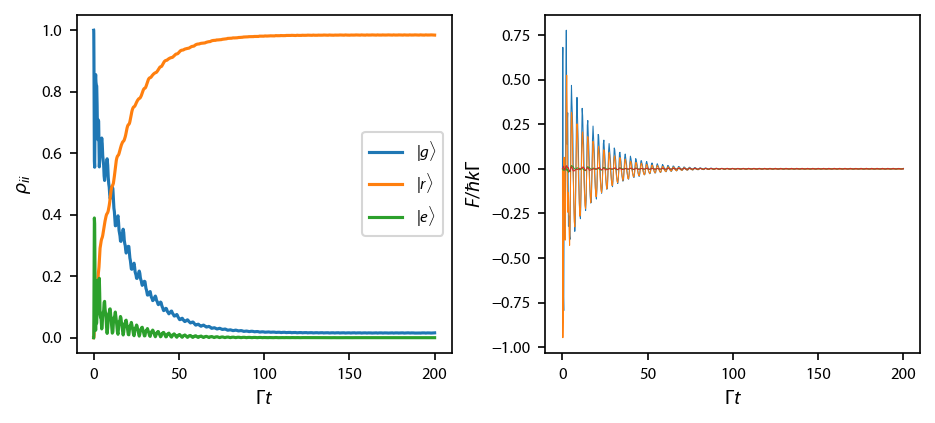

In [3]:
laserBeams = return_three_level_lasers(2*3.4**2, 0.02*2*3.4**2)
hamiltonian = return_three_level_hamiltonian(4.5, 0.1)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                include_mag_forces=False)

obe.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                      np.array([1.0, 0., 0.]))
obe.set_initial_rho_equally()
obe.evolve_density([0, 200])

f, f_laser, f_laser_q, f_mag = obe.force(obe.sol.r, obe.sol.t, obe.sol.rho,
                                         return_details=True)

fig, ax  = plt.subplots(1, 2, figsize=(6.25, 2.75))

ax[0].plot(obe.sol.t, np.real(obe.sol.rho[0, 0]), label='$|g\\rangle$')
ax[0].plot(obe.sol.t, np.real(obe.sol.rho[1, 1]), label='$|r\\rangle$')
ax[0].plot(obe.sol.t, np.real(obe.sol.rho[2, 2]), label='$|e\\rangle$')

ax[1].plot(obe.sol.t, f_laser['g->e'][0][0], linewidth=0.5)
ax[1].plot(obe.sol.t, f_laser['g->e'][0][1], linewidth=0.5)

ax[1].plot(obe.sol.t, f_laser['r->e'][0][0], linewidth=0.5)
ax[1].plot(obe.sol.t, f_laser['r->e'][0][1], linewidth=0.5)

ax[0].set_xlabel('$\Gamma t$')
ax[1].set_xlabel('$\Gamma t$')

ax[0].set_ylabel('$\\rho_{ii}$')
ax[1].set_ylabel('$F/\hbar k \Gamma$')

ax[0].legend(fontsize=8)

fig.subplots_adjust(left=0.08, wspace=0.25)

### Calculate the damping rate

Rather than making a force profile, we are first going to solve at small
velocities and determine the damping coefficent, to compare to Figs. 4/6.  Note
that they fix $\Delta_2$ and change $\Delta_1$ and that $\Delta_2$ is the strong

Completed in 2:41:36.                                               
Completed in 2:34:41.                                               


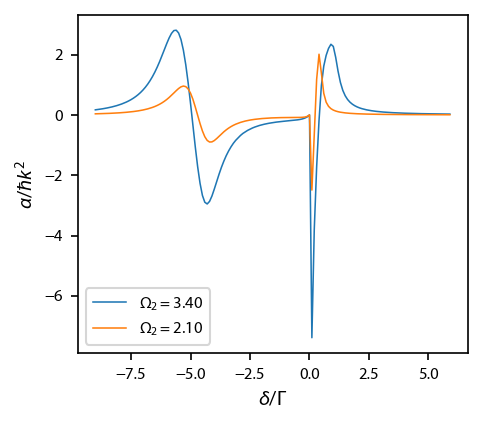

In [4]:
Delta2 = 4.5
deltas = np.arange(-9., 6., 0.1)
Delta1s = Delta2 + deltas
Ires = np.array([2*3.4**2, 2*2.1**2])
Iges = 0.02*Ires

dv = 0.005

alphas = []
for (Ige, Ire) in zip(Iges, Ires):
    it = np.nditer([deltas, Delta1s, None, None])
    progress = progressBar()
    
    for (delta, Delta1, alpha, iterations) in it:
        laserBeams = return_three_level_lasers(Ige, Ire)
        hamiltonian = return_three_level_hamiltonian(Delta1, delta)

        obe = pylcp.obe(laserBeams, magField, hamiltonian,
                            transform_into_re_im=True)

        obe.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                              np.array([dv, 0., 0.]))
        obe.set_initial_rho_equally()
        F = obe.find_equilibrium_force(deltat=2*np.pi*1000, itermax=50)
        alpha[...] = -F[0]/dv
        
        progress.update((it.iterindex+1)/it.itersize)

    alphas.append(it.operands[2])

fig, ax = plt.subplots(1, 1)
for ii, alpha in enumerate(alphas):
    ax.plot(deltas, alpha, label='$\Omega_2=%.2f$' % np.sqrt(Ires[ii]/2),
            linewidth=0.75)
ax.set_xlabel('$\\delta/\Gamma$')
ax.set_ylabel('$\\alpha/\hbar k^2$')
ax.legend(fontsize=8)

Let's take a look at force profiles like Fig. 7.  They divide by the thermal
velocity at 200 uK rather than the Doppler velocity.  So the first step is to f
figure out what the thermal velocity actually is:

import scipy.constants as cts
Li = pylcp.atom.atom('7Li')
vLi = np.sqrt(cts.k*200e-6/Li.mass)/(Li.transition[1].lam/2/np.pi*Li.state[2].gamma)

That works out to be 0.12.  Then the ranges of th plots are 4 times that.  I
think there might be a factor of 2 I am missing somewhere.


Completed in 9:29.                                                  
Completed in 9:01.                                                  
Completed in 11:25.                                                 
Completed in 13:33.                                                 
Completed in 12:58.                                                 
Completed in 14:48.                                                 


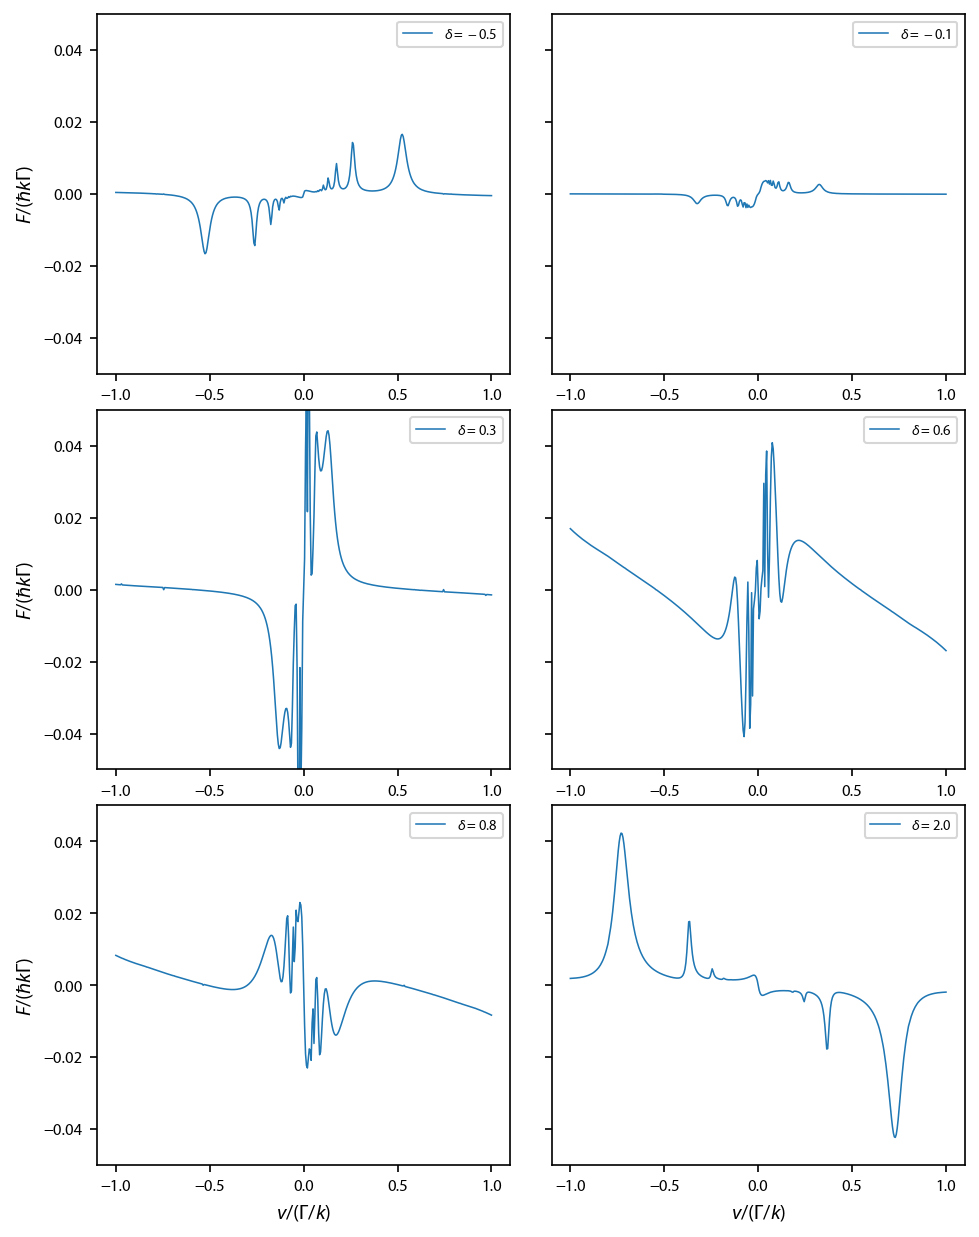

In [5]:
Delta2 = 4.5
deltas = np.array([-0.5, -0.1, 0.3, 0.6, 0.8, 2.0])
Delta1s = Delta2 + deltas
Ire = 2*3.4**2
Ige = 0.02*Ire

obe = {}
v = np.arange(-1, 1.005, 0.005)
for Delta1, delta in zip(Delta1s, deltas):
    laserBeams = return_three_level_lasers(Ige, Ire)
    hamiltonian = return_three_level_hamiltonian(Delta1, delta)

    obe[delta] = pylcp.obe(laserBeams, magField, hamiltonian,
                        transform_into_re_im=True)

    obe[delta].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [v, np.zeros(v.shape), np.zeros(v.shape)],
        name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=2000,
        rel=1e-8, abs=1e-10, progress_bar=True, initial_rho='equally'
    )
    obe[delta].laserBeams['g->e'].beam_vector[1].kvec
    obe[delta].profile['molasses'].f['g->e'].shape

fig, ax = plt.subplots(3, 2, figsize=(6.5, 2.75*3))
for ii, delta in enumerate(deltas):
    ax[int(ii/2), ii%2].plot(v, obe[delta].profile['molasses'].F[0], '-',
                             linewidth=0.75, label='$\delta=%.1f$'%delta)
    ax[int(ii/2), ii%2].legend(fontsize=7)
    ax[int(ii/2), ii%2].set_ylim((-0.05, 0.05))
[ax_i.set_xlabel('$v/(\Gamma/k)$') for ax_i in ax[-1, :]]
[ax_i.set_ylabel('$F/(\hbar k \Gamma)$') for ax_i in ax[:, 0]]
[ax_i.set_yticklabels([]) for ax_i in ax[:, 1]]
fig.subplots_adjust(left=0.09, bottom=0.05)